<div style="text-align: center;">
  <h1>
    Farah Syahirah Binti Rasidi (P151357)
  </h1>
  <h2>
    Assignment 1<br>
    STQD6324 - Data Management<br>
    Semester 2 2024/2025
  </h2>
</div>

<a name="intro"></a>
# Introduction

> The WHO Mortality database is from [WHO](https://www.who.int/data/data-collection-tools/who-mortality-database). The downloaded version can be taken from my [gdrive](https://drive.google.com/drive/folders/14PrwzXTat6caKXj_XuvD0s4IlEoIaibG?usp=drive_link) for reproducibility.

The purpose of this project is to analyze mortality database containing the annual mortality from year 1988 to 2023 across 462776 countries. This database also provide information regarding demographic data such as sex and age and cause-of-death. Multiple tools will be used upon completing this assessment such as Apache Hive, Apache Pig, as well as Python (via Google Colab). 

---

Contents:
*   [Introduction](#intro)
*   [Problem Statement](#problem-statement)
*   [Data Cleaning](#data-cleaning)
*   [Visualization](#visualization)
*   [Insights and Explanations](#InE)
*   [Conclusion](#conclusion)

## File Description

The database contains multiple files of Morticd10 which splits into 6 parts (all mutually exclusive) and one file of country_codes:

> 1.  `Morticd10_part1' (1,022,017 records) - ICD-10 data up to 2002
2.  `Morticd10_part2` ( 958,647 records) – ICD-10 data for 2003-2007
3.  `Morticd10_part3` (1,045,687 records) – ICD-10 data for 2008-2012
3.  `Morticd10_part4` ( 885,319 records) – ICD-10 data for 2013-2016
4.  `Morticd10_part5` ( 863,021 records) – ICD-10 data for 2017-2020
5.  `Morticd10_part6` ( 369,240 records) – ICD-10 data for 2021 onwards
6.  `Country_codes`- Country codes and names. Total records 227)

In [3]:
import pandas as pd
#create file_layout
file_layout = {
    'Column name': ['Country','Admin1','Subdiv','Year','List','Cause','Sex','Frmat','IM_Frmat','Deaths1','Deaths2','Deaths3','Deaths4',
                   'Deaths5','Deaths6','Deaths7','Deaths8','Deaths9','Deaths10','Deaths11','Deaths12','Deaths13','Deaths14','Deaths15',
                   'Deaths16','Deaths17','Deaths18','Deaths19','Deaths20','Deaths21','Deaths22','Deaths23','Deaths24','Deaths25','Deaths26',
                    'IM_deaths1','IM_deaths2','IM_deaths3','IM_deaths4'],
    'Content': ['Country code – see file Country_codes.csv', 'Specified region/Category pertinent to each country', 'Category of data', 
                'Year to which data refer', 'List of ICD revision used', 'Cause of death – For details consult Part 2 below or ICD publications',
                '1 male, 2 female and 9 sex unspecified', 'Age-group format for breakdown of deaths at 0-95+ yrs', 'Age format for breakdown of infant deaths (0 year)',
                'Deaths at all ages', 'Deaths at age 0 year', 'Deaths at age 1 year', 'Deaths at age 2 years', 'Deaths at age 3 years', 
                'Deaths at age 4 years', 'Deaths at age 5-9 years', 'Deaths at age 10-14 years', 'Deaths at age 15-19 years',
                'Deaths at age 20-24 years', 'Deaths at age 25-29 years', 'Deaths at age 30-34 years', 'Deaths at age 35-39 years',
                'Deaths at age 40-44 years', 'Deaths at age 45-49 years', 'Deaths at age 50-54 years', 'Deaths at age 55-59 years', 'Deaths at age 60-64 years',
                'Deaths at age 65-69 years', 'Deaths at age 70-74 years', 'Deaths at age 75-79 years', 'Deaths at age 80-84 years', 'Deaths at age 85-89 years',
                'Deaths at age 90-94 years', 'Deaths at age 95 years and above', 'Deaths at age unspecified', 'Infant deaths at age 0 day',
                'Infant deaths at age 1-6 days', 'Infant deaths at age 7-27 days', 'Infant deaths at age 28-364 days']
}

# Create DataFrame based on file_layout
fl = pd.DataFrame(file_layout)

### File layout

For files of Morticd10, the layout for each line of data is as follows:

In [4]:
print(fl.to_markdown(index=False))     #display table

| Column name   | Content                                                               |
|:--------------|:----------------------------------------------------------------------|
| Country       | Country code – see file Country_codes.csv                             |
| Admin1        | Specified region/Category pertinent to each country                   |
| Subdiv        | Category of data                                                      |
| Year          | Year to which data refer                                              |
| List          | List of ICD revision used                                             |
| Cause         | Cause of death – For details consult Part 2 below or ICD publications |
| Sex           | 1 male, 2 female and 9 sex unspecified                                |
| Frmat         | Age-group format for breakdown of deaths at 0-95+ yrs                 |
| IM_Frmat      | Age format for breakdown of infant deaths (0 year)                    |
| Deaths1 

<a name="problem-statement"></a>
# Problem Statement

As a future data scientist, I am interested in the relationship between the deaths and demographic variables which are country, sex and age group. This analysis aims to understand the trend or pattern of the dataset and understand the working relationship between corresponding variables to the number of deaths. The working analysis can be broken down into:


> 1.   [Descriptive Analytics](#descr-analytics)
>> *   What are the proportions of total deaths in difference age group and sex across different countries?
>> *   What is the trend of deaths for each age group?
> 3.   [Comparison Analytics](#comp-analytics)
>> *   Is there a significant difference in mortality rates from cardiovascular diseases between early-old (65–74), middle-old (75–84) and oldest old populations?
>> *   How differ the three most high cause of deaths of oldest-old (85+) age group between United States of America and Russian Federation?

In [1]:
#connect jupyter to hdp
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='DM_Asg1',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute('''
select *
from morticd10_part6            
''')
print(cursor.fetchall())


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Data Cleaning

In [4]:
# Install all the required packages
import pandas as pd               #for handling data
import numpy as np                #for numerical computation
import matplotlib.pyplot as plt   #for plotting or visualization
from pmdarima import auto_arima   #for forecasting time series data
import seaborn as sns             #for plotting or graph visualization

In [223]:
dataframe= []  #make empty list for looping the files inside the tuple

# looping files and add files in the empty tuple of dataframe
for i in range(1,7):
    csvfile= f'Morticd10_part{i}.csv' #Morticd10_part is the name of the file
    mortality= pd.read_csv(csvfile)   #read each file
    dataframe.append(mortality)       #append/add file

combined_mortality= pd.concat(dataframe, ignore_index=True) #combine all dataframes to become a new single dataframe

print(combined_mortality.head(5))

C:\Users\user\AppData\Local\Temp\ipykernel_17104\1895969132.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_17104\1895969132.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_17104\1895969132.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_17104\1895969132.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_17104\1895969132.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype opti

   Country  Admin1 SubDiv  Year List Cause  Sex  Frmat  IM_Frmat  Deaths1  \
0     1400     NaN    NaN  2001  101  1000    1      7         8      332   
1     1400     NaN    NaN  2001  101  1000    2      7         8      222   
2     1400     NaN    NaN  2001  101  1001    1      7         8       24   
3     1400     NaN    NaN  2001  101  1001    2      7         8       14   
4     1400     NaN    NaN  2001  101  1002    1      7         8        0   

   ...  Deaths21  Deaths22  Deaths23  Deaths24  Deaths25  Deaths26  \
0  ...      95.0       NaN       NaN       NaN       NaN       0.0   
1  ...     112.0       NaN       NaN       NaN       NaN       0.0   
2  ...       5.0       NaN       NaN       NaN       NaN       0.0   
3  ...       6.0       NaN       NaN       NaN       NaN       0.0   
4  ...       0.0       NaN       NaN       NaN       NaN       0.0   

   IM_Deaths1  IM_Deaths2  IM_Deaths3  IM_Deaths4  
0         8.0         NaN         NaN         NaN  
1        11.

In [163]:
combined_mortality.info() #check column type, missing entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5143931 entries, 0 to 5143930
Data columns (total 39 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     int64  
 1   Admin1      float64
 2   SubDiv      object 
 3   Year        int64  
 4   List        object 
 5   Cause       object 
 6   Sex         int64  
 7   Frmat       int64  
 8   IM_Frmat    int64  
 9   Deaths1     int64  
 10  Deaths2     float64
 11  Deaths3     float64
 12  Deaths4     float64
 13  Deaths5     float64
 14  Deaths6     float64
 15  Deaths7     float64
 16  Deaths8     float64
 17  Deaths9     float64
 18  Deaths10    float64
 19  Deaths11    float64
 20  Deaths12    float64
 21  Deaths13    float64
 22  Deaths14    float64
 23  Deaths15    float64
 24  Deaths16    float64
 25  Deaths17    float64
 26  Deaths18    float64
 27  Deaths19    float64
 28  Deaths20    float64
 29  Deaths21    float64
 30  Deaths22    float64
 31  Deaths23    float64
 32  Deaths24    float64
 33  Deaths2

In [7]:
combined_mortality.duplicated().any() #check for repeated rows

False

In [8]:
combined_mortality.isna().sum() #check for the total of NA value in each column

Country             0
Admin1        5059758
SubDiv        5136458
Year                0
List                0
Cause               0
Sex                 0
Frmat               0
IM_Frmat            0
Deaths1             0
Deaths2         77117
Deaths3         77117
Deaths4        348480
Deaths5        348480
Deaths6        348480
Deaths7         77117
Deaths8         81099
Deaths9         77117
Deaths10        81099
Deaths11        77117
Deaths12        81099
Deaths13        77117
Deaths14        81099
Deaths15        77117
Deaths16        81099
Deaths17        77117
Deaths18        81099
Deaths19        77117
Deaths20        81423
Deaths21        77441
Deaths22       102846
Deaths23       102846
Deaths24       765213
Deaths25       765213
Deaths26        83483
IM_Deaths1      77117
IM_Deaths2    1116341
IM_Deaths3    1032539
IM_Deaths4    1032539
dtype: int64

### Handling Missing Entries/NA

As per WHO guidlines, in the data, NA denotes unavalaible or not recorded data due to incomplete registration coverage, non-reporting or exclusion from the vital registration systems's scope. 

Hence, for this analysis, NA means 'no deaths occurred'. The columns is then grouped with other columns to match the age group according to gerontological standards.

### Age Group Category
the age group is very large. Hence, I decided to group the age into five groups:

>1) **Young Age** group that consists of:
    - Infant -(0-1) age
    - Early_childhood -(2-5) age
    - Middle_childhood -(6-11) age
    - Adolescence -(12-17) age
    - Young_Adult -(18-24) age
    - Adult -(25-44) age


>2) **Middle Age** group (45-64) age

>3) **Early_old Age** group (65-74) age

>4) **Middle_old Age** group (75-84) age

>5) **Oldest_old Age** group (85+) age

Note: 
Age groups follow gerontological standards: Early-old (65-74), Middle-old (75-84) and Oldest-old (85+). Sources: NIA, WHO and Neugarten (1974).
- Link: [NIA Aging Categories](https://www.nia.nih.gov/). [WHO Aging Report](https://www.who.int/news-room/fact-sheets/detail/ageing-and-health)
- Gerontology Journals. DOI: [10.2307/2094307](https://doi.org/10.2307/2094307)

In [9]:
m= combined_mortality.copy() #create new name gd (group death) without changing the original dataframe

#Create new column 'children' that summed up each rows
m['Young']= m[['IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4','Deaths3', 'Deaths4', 'Deaths5', 'Deaths6', 'Deaths7','Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12', 'Deaths13', 'Deaths14']].sum(axis= 1) 

#Create new column 'Middle_age' that summed up each rows
m['Middle_age']= m[['Deaths15', 'Deaths16', 'Deaths17', 'Deaths18']].sum(axis= 1)

# create Early old column
m['Early_old']= m[['Deaths19', 'Deaths20']].sum(axis=1)

# create middle_old column
m['Middle_old']= m[['Deaths21', 'Deaths22']].sum(axis=1)

#Create new column 'Oldest_old' that summed up each rows
m['Oldest_old']= m[['Deaths23', 'Deaths24', 'Deaths25']].sum(axis= 1)

### Columns removal
>1) **'Admin1', 'SubDiv'**
>> There's insufficient of information in columns 'Admin1' and 'Subdiv' which represent specified region and category of data respectively. When both fields 'Admin1' and 'Subdiv' are blank, data reported refer to the country. Hence, both columns were removed and 'Country' column is enough to represent the data.
>2) **'Deaths1 and Deaths26'**
>> Deaths1 is representing data at all ages while Deaths26 has unspecified age. Both are removed to have clearer data analysis.
>3) **'Deaths2', 'Deaths3', 'Deaths4', 'Deaths5', 'Deaths6', 'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12', 'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17', 'Deaths18', 'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23', 'Deaths24', 'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'**
>> Columns were removed after grouping repective columns into their respective age group.

In [10]:
#remove column
m_drop= m.drop(columns= ['Admin1', 'SubDiv', 'Frmat', 'IM_Frmat', 
                          'Deaths1', 'Deaths2', 'Deaths3', 'Deaths4', 'Deaths5',
                          'Deaths6', 'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11',
                          'Deaths12', 'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17',
                          'Deaths18', 'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23',
                          'Deaths24', 'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2',
                          'IM_Deaths3', 'IM_Deaths4'])

m_drop['Sex']= m_drop['Sex'].replace({1: 'Male', 2: 'Female'}) #label Sex to Male and Female
m_drop= m_drop[m_drop['Sex']!= 9] #remove unspecified sex=9 to have clear analysis for male and female
m_drop['Sex'].unique() #check unique value of SEX

array(['Male', 'Female'], dtype=object)

In [11]:
m_drop.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
4,1400,2001,101,1002,Male,0.0,0.0,0.0,0.0,0.0


In [12]:
m_drop['Country'].unique().sum()

462776

In [13]:
m_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5119607 entries, 0 to 5143930
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     int64  
 1   Year        int64  
 2   List        object 
 3   Cause       object 
 4   Sex         object 
 5   Young       float64
 6   Middle_age  float64
 7   Early_old   float64
 8   Middle_old  float64
 9   Oldest_old  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 429.7+ MB


### Handle duplicates

After grouping the age group there's sligtly a changes in the shape and information of the new dataframe ('m_drop' dataframe). The data is checked for its duplicity to ensure whether the duplicates is actually redundant rows or the repeated is only on object columns. 

In [14]:
print(m_drop.duplicated().sum())

23371


In [15]:
subsetduplicates= m_drop[m_drop.duplicated(subset= ['Country', 'Cause', 'Sex'], keep=False)]
subsetduplicates.head(20)

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
4,1400,2001,101,1002,Male,0.0,0.0,0.0,0.0,0.0
5,1400,2001,101,1002,Female,0.0,0.0,0.0,0.0,0.0
6,1400,2001,101,1003,Male,0.0,0.0,0.0,0.0,0.0
7,1400,2001,101,1003,Female,0.0,0.0,0.0,0.0,0.0
8,1400,2001,101,1004,Male,0.0,0.0,0.0,0.0,0.0
9,1400,2001,101,1004,Female,0.0,0.0,0.0,0.0,0.0


**Decision in duplicate rows**
>In this data, the repeated rows are rows with zero values of numerical columns. Hence, I will remove the rows only that all have zero numerical columns in order to obtain clean data and provide clarity in analysis.

In [16]:
#select only numerical column of age group
numerical_cols= m_drop.select_dtypes(include='float64').columns 

#mark the rows that have 0 values 
zero_numerical= (m_drop[numerical_cols]==0).all(axis=1)
zero_rowsvalue= m_drop[zero_numerical]

zero_rowsvalue

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
4,1400,2001,101,1002,Male,0.0,0.0,0.0,0.0,0.0
5,1400,2001,101,1002,Female,0.0,0.0,0.0,0.0,0.0
6,1400,2001,101,1003,Male,0.0,0.0,0.0,0.0,0.0
7,1400,2001,101,1003,Female,0.0,0.0,0.0,0.0,0.0
8,1400,2001,101,1004,Male,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5042983,1360,2022,104,R02,Female,0.0,0.0,0.0,0.0,0.0
5042984,1360,2022,104,I210,Female,0.0,0.0,0.0,0.0,0.0
5042985,1360,2022,104,M349,Female,0.0,0.0,0.0,0.0,0.0
5109801,4180,2021,104,X38,Female,0.0,0.0,0.0,0.0,0.0


In [17]:
# drop all rows with zero values to have a clean data to analyse
grouped_mortality= m_drop[~zero_numerical]

print('Shape of m_drop dataframe with duplicate rows:')
print(m_drop.shape)
print('Shape of grouped_mortality dataframe  after removing zero numerical values:')
print(grouped_mortality.shape)

Shape of m_drop dataframe with duplicate rows:
(5119607, 10)
Shape of grouped_mortality dataframe  after removing zero numerical values:
(5033838, 10)


In [18]:
#check whether the total duplicate rows tally or not 
5119607-5033838

85769

In [19]:
grouped_mortality.isna().sum() #check for any missing value/entries in the new dataframe

Country       0
Year          0
List          0
Cause         0
Sex           0
Young         0
Middle_age    0
Early_old     0
Middle_old    0
Oldest_old    0
dtype: int64

# Visualization &
# Insights and Explanation

In [20]:
grouped_mortality.describe().round()

,Country,Year,Young,Middle_age,Early_old,Middle_old,Oldest_old
count,5033838.0,5033838.0,5033838.0,5033838.0,5033838.0,5033838.0,5033838.0
mean,3293.0,2010.0,22.0,38.0,35.0,49.0,44.0
std,988.0,7.0,935.0,1563.0,1394.0,1895.0,1950.0
min,1030.0,1988.0,0.0,0.0,0.0,0.0,0.0
25%,2310.0,2004.0,0.0,0.0,0.0,0.0,0.0
50%,3365.0,2010.0,1.0,1.0,0.0,0.0,0.0
75%,4188.0,2016.0,2.0,2.0,2.0,2.0,1.0
max,5198.0,2023.0,252725.0,470852.0,418941.0,432389.0,617885.0


In [21]:
grouped_mortality.describe(include='object')

,List,Cause,Sex
count,5033838,5033838,5033838
unique,5,11485,2
top,104,AAA,Male
freq,4609185,4916,2643829


#### Deaths distribution in different Age Group

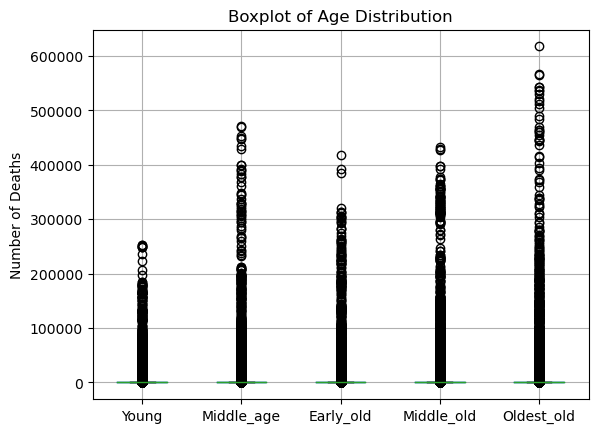

In [22]:
grouped_mortality[['Young', 'Middle_age', 'Early_old', 'Middle_old', 'Oldest_old']].boxplot()
plt.title('Boxplot of Age Distribution')
plt.ylabel('Number of Deaths')
plt.show()

**From 1988-2023 the highest deaths number is from the oldest-old group and the least is young group**

#### 1) What are the proportions of total deaths in difference age group and sex across different countries?

In [23]:
grouped_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


In [24]:
young_countrysex= grouped_mortality.groupby(['Country', 'Sex'])['Young'].sum().sort_values(ascending=False)
ma_countrysex= grouped_mortality.groupby(['Country', 'Sex'])['Middle_age'].sum().sort_values(ascending=False)
eo_countrysex= grouped_mortality.groupby(['Country', 'Sex'])['Early_old'].sum().sort_values(ascending=False)
mo_countrysex= grouped_mortality.groupby(['Country', 'Sex'])['Middle_old'].sum().sort_values(ascending=False)
oldest_countrysex= grouped_mortality.groupby(['Country', 'Sex'])['Oldest_old'].sum().sort_values(ascending=False)

top_cyoung= young_countrysex.head(10)
top_cma= ma_countrysex.head(10)
top_eo= eo_countrysex.head(10)
top_mo= mo_countrysex.head(10)
top_oldest= oldest_countrysex.head(10)

In [25]:
# label country to their respective name
code= pd.read_csv('country_codes.csv')
top_cyoung1= pd.merge(top_cyoung.unstack(), code, on='Country', how= 'left').drop(columns='Country').rename(columns={'Name':'Country'}).set_index('Country')
top_cma1= pd.merge(top_cma.unstack(), code, on='Country', how= 'left').drop(columns='Country').rename(columns={'Name':'Country'}).set_index('Country')
top_eo1= pd.merge(top_eo.unstack(), code, on='Country', how= 'left').drop(columns='Country').rename(columns={'Name':'Country'}).set_index('Country')
top_mo1= pd.merge(top_mo.unstack(), code, on='Country', how= 'left').drop(columns='Country').rename(columns={'Name':'Country'}).set_index('Country')
top_oldest1= pd.merge(top_oldest.unstack(), code, on='Country', how= 'left').drop(columns='Country').rename(columns={'Name':'Country'}).set_index('Country')

print("Death of Young age by Sex and Country")
print(top_cyoung1)
print('\n')
print("Death of Middle age by Sex and Country")
print(top_cma1)
print('\n')
print("Death of Early-Old age by Sex and Country")
print(top_eo1)
print('\n')
print("Death of Middle-Old age by Sex and Country")
print(top_mo1)
print('\n')
print("Death of Oldest-Old agae by Sex and Country")
print(top_oldest1)

Death of Young age by Sex and Country
                             Female        Male
Country                                        
Russian Federation        3887183.0  11815073.0
Brazil                    5110872.0  11281938.0
United States of America  3352178.0   6324300.0
South Africa              4896006.0   5714618.0
Mexico                          NaN   4315430.0
Thailand                        NaN   3199316.0


Death of Middle age by Sex and Country
                              Female        Male
Country                                         
Russian Federation        10290246.0  24032952.0
United States of America   9399100.0  14701830.0
Brazil                     6600676.0  10924760.0
Japan                            NaN   5144676.0
Mexico                           NaN   4303648.0
Ukraine                          NaN   4134544.0
South Africa                     NaN   3657612.0


Death of Early-Old age by Sex and Country
                              Female        Male
Cou

C:\Users\user\AppData\Local\Temp\ipykernel_17104\1173553982.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad= 5.0)


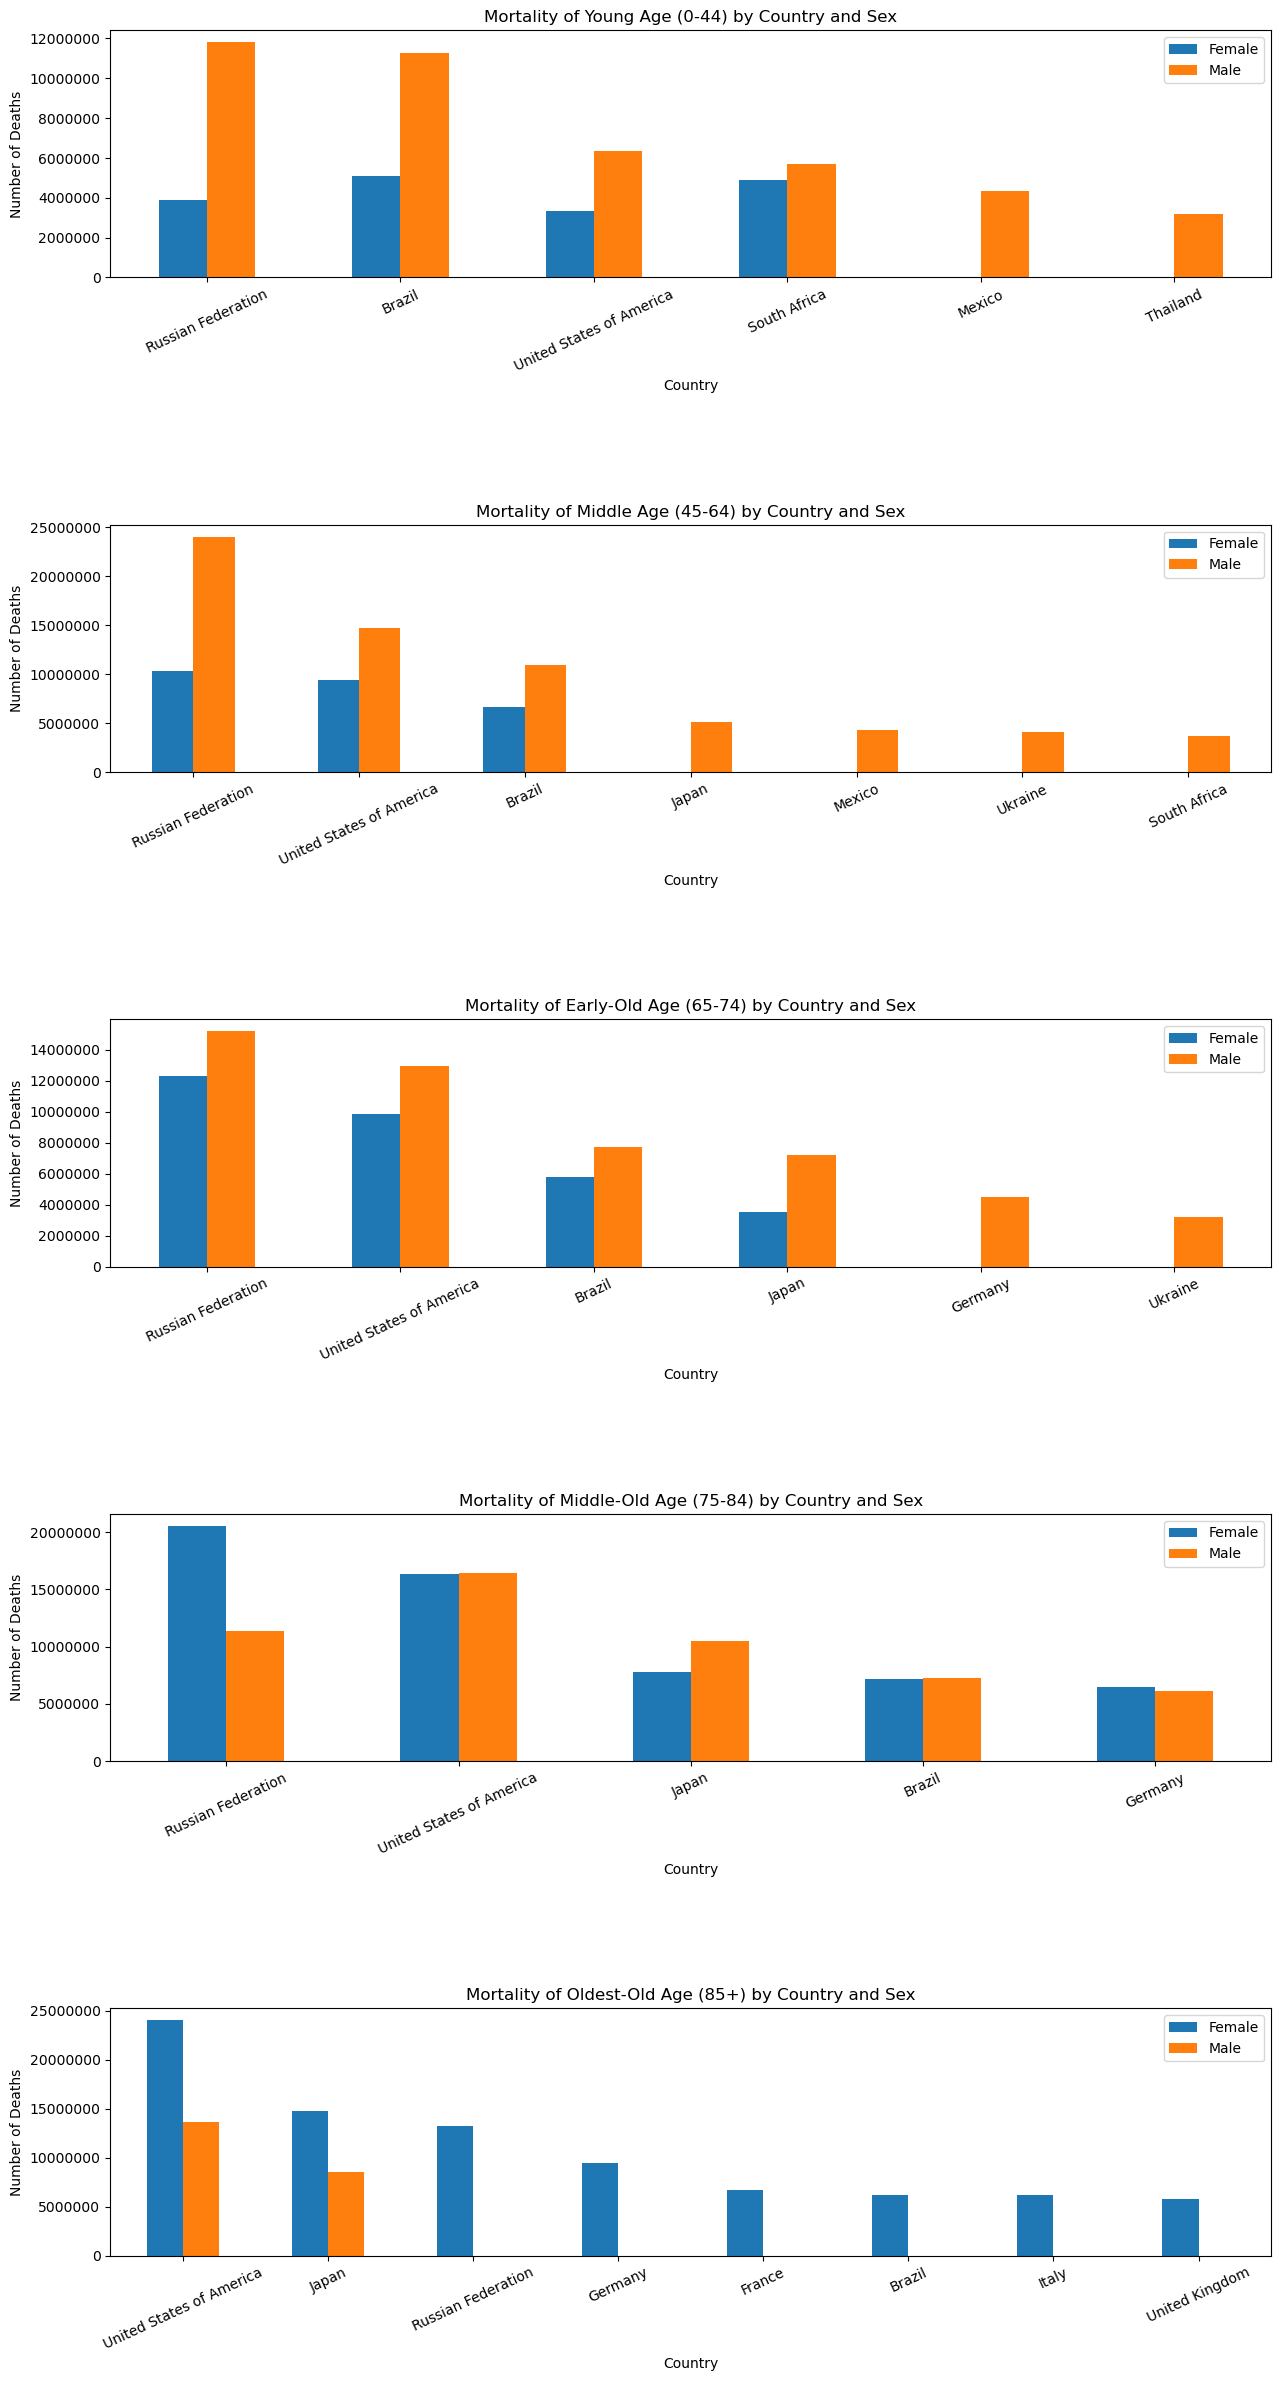

In [40]:
fig, axes= plt.subplots(nrows=5, ncols=1, figsize=(14,25), constrained_layout=True)
axes= axes.flatten()

top_cyoung1.plot(ax=axes[0], kind='bar')
axes[0].set_title('Mortality of Young Age (0-44) by Country and Sex')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of Deaths')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].tick_params(axis='x', labelsize=10, labelrotation=25)

top_cma1.plot(ax=axes[1], kind='bar')
axes[1].set_title('Mortality of Middle Age (45-64) by Country and Sex')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of Deaths')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].tick_params(axis='x', labelsize=10, labelrotation=25)

top_eo1.plot(ax=axes[2], kind='bar')
axes[2].set_title('Mortality of Early-Old Age (65-74) by Country and Sex')
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Number of Deaths')
axes[2].ticklabel_format(style='plain', axis='y')
axes[2].tick_params(axis='x', labelsize=10, labelrotation=25)

top_mo1.plot(ax=axes[3], kind='bar')
axes[3].set_title('Mortality of Middle-Old Age (75-84) by Country and Sex')
axes[3].set_xlabel('Country')
axes[3].set_ylabel('Number of Deaths')
axes[3].ticklabel_format(style='plain', axis='y')
axes[3].tick_params(axis='x', labelsize=10, labelrotation=25)

top_oldest1.plot(ax=axes[4], kind='bar')
axes[4].set_title('Mortality of Oldest-Old Age (85+) by Country and Sex')
axes[4].set_xlabel('Country')
axes[4].set_ylabel('Number of Deaths')
axes[4].ticklabel_format(style='plain', axis='y')
axes[4].tick_params(axis='x', labelsize=10, labelrotation=25)

plt.tight_layout(pad= 5.0)
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

>- The most frequent gender with the highest deaths is Male
>- Male has highest deaths at group of Young age, Middle age and Early-old age which means most of them die younger below <75 age
>- This means, Females tend to live longer and this gender has higher deaths number at age of 75+
>- The most country with highest deaths rate ranked from:
>>- 1) Russian Federation
>>- 2) United States of America
>>- 3) Brazil

In [27]:
grouped_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


#### 2) What is the trend of deaths for each age group?

In [28]:
young_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Young'].sum().unstack()
middle_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Middle_age'].sum().unstack()
eo_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Early_old'].sum().unstack()
mo_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Middle_old'].sum().unstack()
oldest_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Oldest_old'].sum().unstack()

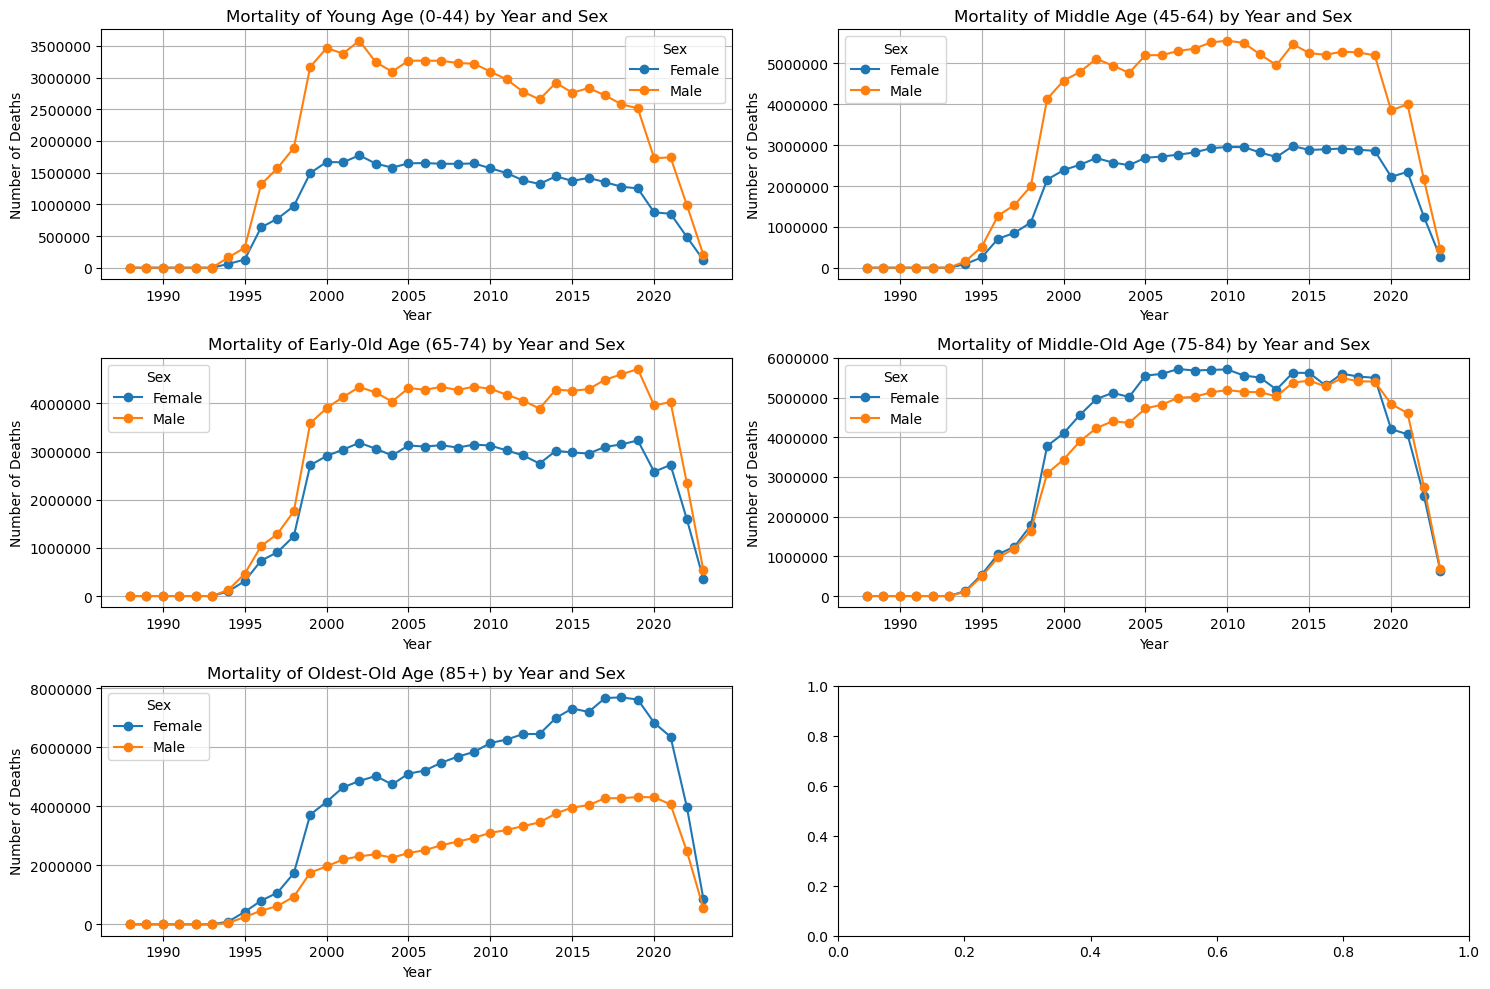

In [41]:
fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(15,10))

young_yearsex.plot(ax= axes[0,0], marker='o')
axes[0,0].set_title('Mortality of Young Age (0-44) by Year and Sex')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Number of Deaths')
axes[0,0].grid(True)
axes[0,0].ticklabel_format(style='plain', axis='y')

middle_yearsex.plot(ax= axes[0,1], marker='o')
axes[0,1].set_title('Mortality of Middle Age (45-64) by Year and Sex')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Number of Deaths')
axes[0,1].grid(True)
axes[0,1].ticklabel_format(style='plain', axis='y')

eo_yearsex.plot(ax= axes[1,0], marker='o')
axes[1,0].set_title('Mortality of Early-0ld Age (65-74) by Year and Sex')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Deaths')
axes[1,0].grid(True)
axes[1,0].ticklabel_format(style='plain', axis='y')

mo_yearsex.plot(ax= axes[1,1], marker='o')
axes[1,1].set_title('Mortality of Middle-Old Age (75-84) by Year and Sex')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Number of Deaths')
axes[1,1].grid(True)
axes[1,1].ticklabel_format(style='plain', axis='y')

oldest_yearsex.plot(ax= axes[2,0], marker='o')
axes[2,0].set_title('Mortality of Oldest-Old Age (85+) by Year and Sex')
axes[2,0].set_xlabel('Year')
axes[2,0].set_ylabel('Number of Deaths')
axes[2,0].grid(True)
axes[2,0].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show();

>- Based on the graph above, we observed that the trend of mortality over the years from 1988-2023 for each age group and their respective gender:
>>- All data from year 1988-1993 are at 0 mortality or lower rates of deaths and increasing from 1994-2000.
>>- The deaths rate pattern seems stable or constant after 2000 until 2018 which all the graphs have sharp decrease of deaths rate for all age group.

>- **(1988-1993)**
>>- Zero or lower rates of deaths. This probably that insufficient data was collected earlier because most of the country didn't start reporting. It doesn't mean that zero deaths occurred, just that no data has been reported within these years.
>- **(1994-2020)**
>>- The deaths rate increases as more countries started to use digitalised recorded and joined the database.
>- **(2000-2018)**
>>- Stable deaths rate as most of the countries maintained reporting the deaths rate. All age group shows stable deaths rate except for Oldest-old age group which the number of deaths inreases within these range year.
>- **(2019-2023)**
>>- Sharp drop of deaths rate for all age group might due to pandemic Covid-19. There's delay in reporting and confirmed by WHO
>>>- "There is a delay of 1–2 years between the end of a calendar year and the availability of death data."
>>- Incomplete and fail in maintaining good reporting and some countries paused and has lower mortality as they delay the submission of the mortality record numbers.

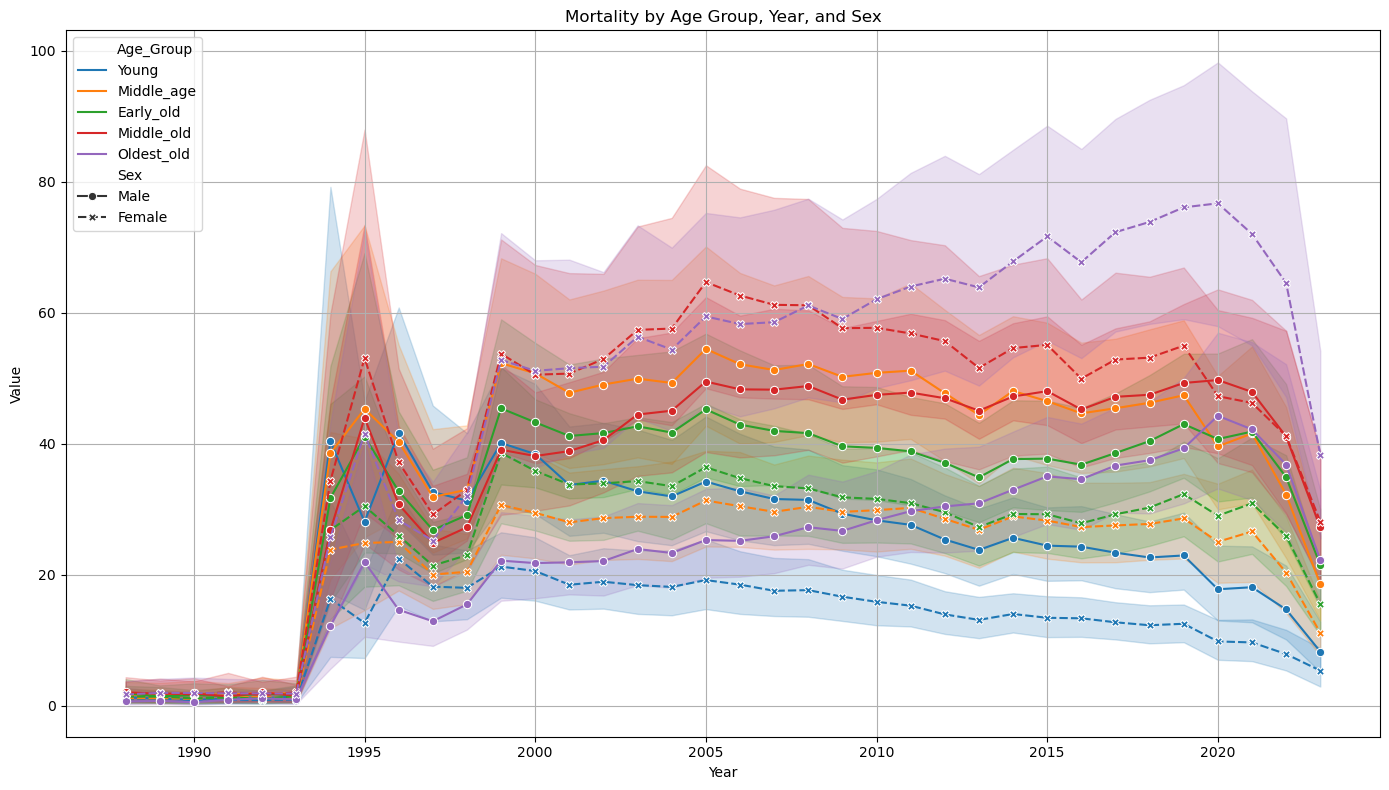

In [42]:
#Melt grouped_mortality dataframe from wide to long format
melted_groupedmortality = grouped_mortality.melt(id_vars=['Year', 'Sex'], value_vars=['Young', 'Middle_age', 'Early_old', 'Middle_old', 'Oldest_old'], var_name='Age_Group', value_name='Value')

plt.figure(figsize=(14, 8))
sns.lineplot(data=melted_groupedmortality, x='Year', y='Value', hue='Age_Group', style='Sex', markers=True)

plt.title('Mortality by Age Group, Year, and Sex')
plt.ylabel('Value')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.tight_layout()
plt.show();

## Comparison Analytics

#### 1) Is there a significant difference in mortality rates from cardiovascular diseases between early-old (65–74), middle-old (75–84) and oldest old populations?

>- Based on the cause of deaths above, I filter most 15 highest cause of death and find the respective name for each group from the website of International Cause of Disease [ICD](https://icd.who.int/browse10/2019/en#/I20-I25).
>- List 103 and 104 are the general codes for disease that is used when detail information of specific cause of death is unavailable.
>- Note that cause "AAA" and '1000' refers to total deaths from all causes combined. Hence, for clearer analysis, I will only analyse other specific disease that lead to highest number of deaths.

##### Old Group analysis

>- Since the data shows insufficient information as we found out in previous analysis, I will further analyse the stable data to avoid misintepretation of data from the year 2000-2018

In [237]:
#Extract data from year 2000-2018
stable_mortality= grouped_mortality[(grouped_mortality['Year']>=2000) & (grouped_mortality['Year']<=2018)]
stable_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


In [207]:
earlyold_listcause= stable_mortality.groupby(['List', 'Cause'], as_index= False)['Early_old'].sum().sort_values(by='Early_old', ascending=False).head(10)
middleold_listcause= stable_mortality.groupby(['List', 'Cause'], as_index=False)['Middle_old'].sum().sort_values(by='Middle_old', ascending=False).head(10)
oldestold_listcause= stable_mortality.groupby(['List', 'Cause'], as_index=False)['Oldest_old'].sum().sort_values(by='Oldest_old', ascending=False).head(10)

In [208]:
print(earlyold_listcause)
print('\n')
print(middleold_listcause)
print('\n')
print(oldestold_listcause)

     List Cause   Early_old
2146  104   AAA  45666165.0
0     101  1000  11042664.0
191   103   AAA   7018696.0
64    101  1064   6957288.0
67    101  1067   3862499.0
2652  104  C349   3483380.0
4741  104  I219   3083624.0
69    101  1069   2234975.0
26    101  1026   2153933.0
5147  104  J449   1245646.0


     List Cause  Middle_old
2146  104   AAA  69698830.0
0     101  1000  13427473.0
64    101  1064   9710744.0
191   103   AAA   7604174.0
67    101  1067   5297602.0
4741  104  I219   4305191.0
69    101  1069   3274237.0
2652  104  C349   3242479.0
4899  104   I64   2564708.0
4750  104  I251   2221103.0


     List Cause  Oldest_old
2146  104   AAA  71555718.0
0     101  1000   6899882.0
64    101  1064   4911966.0
191   103   AAA   3943629.0
4741  104  I219   3754133.0
5071  104  J189   3227662.0
3787  104   F03   3064751.0
4899  104   I64   2932915.0
4750  104  I251   2807910.0
67    101  1067   2591052.0


>- **Cardiovascular Diseases**
related to the heart of blood vessels:
>>- 1064: Disease of the circulatory system
>>- 1067: Ischaemic heart diseases
>>- I219: Acute myocardial infarction
>>- I251: Atherosclerotic heart disease
>>- 1069: Cerebrovascular diseases
>>- I64: Stroke 

>- **Respiratory Diseases** 
affect the lungs:
>>- J449: Chronic obstructive pulmonary disease
>>- J189: Pneumonia

>- **Cancer/Neoplasm**
>>- 1026: Neoplasm
>>- C349: Malignant neoplasm of trachea, bronchus and lung


>- **Neurological/Mental Health**
>>- F03: Unspecified dementia

>- **Geriatric**
>>- R54: Senility

>- **J189**
>>- Influenza & Pneumonia

In [226]:
cause_map= {
    '1064': 'Cardiovascular Diseases',
    '1067': 'Cardiovascular Diseases',
    'I219': 'Cardiovascular Diseases',
    'I251': 'Cardiovascular Diseases',
    '1069': 'Cardiovascular Diseases',
    'I64': 'Cardiovascular Diseases',
    'J449': 'Respiratory Diseases',
    'JI89': 'Respiratory Diseases',
    'C349': 'Cancers/Neoplasm',
    '1026': 'Cancers/Neoplasm',
    'F03': 'Neurological/Mental Health',
    'R54': 'Geriatric',
    'J189': 'Influenza and Pneumonia'
}

In [227]:
# remove the all causes of death (AAA, 1000)
earlyold_listcause= earlyold_listcause[~earlyold_listcause['Cause'].isin(['AAA', '1000'])]
middleold_listcause= middleold_listcause[~middleold_listcause['Cause'].isin(['AAA', '1000'])]
oldestold_listcause= oldestold_listcause[~oldestold_listcause['Cause'].isin(['AAA', '1000'])]

# name the cause of death for each group
earlyold_causedeath= earlyold_listcause.copy()
earlyold_causedeath['Death_cause']= earlyold_causedeath['Cause'].map(cause_map)

middleold_causedeath= middleold_listcause.copy()
middleold_causedeath['Death_cause']= middleold_causedeath['Cause'].map(cause_map)

oldestold_causedeath= oldestold_listcause.copy()
oldestold_causedeath['Death_cause']= oldestold_causedeath['Cause'].map(cause_map)

In [228]:
print(earlyold_causedeath)
print('\n')
print(middleold_causedeath)
print('\n')
print(oldestold_causedeath)

     List Cause  Early_old              Death_cause
64    101  1064  6957288.0  Cardiovascular Diseases
67    101  1067  3862499.0  Cardiovascular Diseases
2652  104  C349  3483380.0         Cancers/Neoplasm
4741  104  I219  3083624.0  Cardiovascular Diseases
69    101  1069  2234975.0  Cardiovascular Diseases
26    101  1026  2153933.0         Cancers/Neoplasm
5147  104  J449  1245646.0     Respiratory Diseases


     List Cause  Middle_old              Death_cause
64    101  1064   9710744.0  Cardiovascular Diseases
67    101  1067   5297602.0  Cardiovascular Diseases
4741  104  I219   4305191.0  Cardiovascular Diseases
69    101  1069   3274237.0  Cardiovascular Diseases
2652  104  C349   3242479.0         Cancers/Neoplasm
4899  104   I64   2564708.0  Cardiovascular Diseases
4750  104  I251   2221103.0  Cardiovascular Diseases


     List Cause  Oldest_old                 Death_cause
64    101  1064   4911966.0     Cardiovascular Diseases
4741  104  I219   3754133.0     Cardiovascul

In [229]:
#drop the code cause column in each old group
earlyold_causedeath1= earlyold_causedeath.groupby('Death_cause', as_index=False)['Early_old'].sum()
middleold_causedeath1= middleold_causedeath.groupby('Death_cause', as_index=False)['Middle_old'].sum()
oldestold_causedeath1= oldestold_causedeath.groupby('Death_cause', as_index=False)['Oldest_old'].sum()

print(earlyold_causedeath1)
print('\n')
print(middleold_causedeath1)
print('\n')
print(oldestold_causedeath1)

               Death_cause   Early_old
0         Cancers/Neoplasm   5637313.0
1  Cardiovascular Diseases  16138386.0
2     Respiratory Diseases   1245646.0


               Death_cause  Middle_old
0         Cancers/Neoplasm   3242479.0
1  Cardiovascular Diseases  27373585.0


                  Death_cause  Oldest_old
0     Cardiovascular Diseases  16997976.0
1     Influenza and Pneumonia   3227662.0
2  Neurological/Mental Health   3064751.0


In [216]:
combine_causedeatholdgroup= pd.concat([earlyold_causedeath1, middleold_causedeath1, oldestold_causedeath1], ignore_index=True)
combine_causedeatholdgroup= combine_causedeatholdgroup.groupby('Death_cause', as_index=False).sum(numeric_only=True)
combine_causedeatholdgroup

,Death_cause,Early_old,Middle_old,Oldest_old
0,Cancers/Neoplasm,5637313.0,3242479.0,0.0
1,Cardiovascular Diseases,16138386.0,27373585.0,16997976.0
2,Neurological/Mental Health,0.0,0.0,3064751.0
3,Respiratory Diseases,1245646.0,0.0,0.0


In [218]:
old_disease= combine_causedeatholdgroup[combine_causedeatholdgroup['Death_cause']=='Cardiovascular Diseases']

old_disease= old_disease.rename(columns={
    'Early_old': '65-74',
    'Middle_old': '75-84',
    'Oldest_old': '85+'
})

In [219]:
old_disease

,Death_cause,65-74,75-84,85+
1,Cardiovascular Diseases,16138386.0,27373585.0,16997976.0


In [220]:
#melt the old_disease to create a new long format df 
old_disease1= old_disease.melt(id_vars='Death_cause', var_name='Age_Group', value_name='Deaths_number')

#to rename the age group
old_disease1['Age_Group']= old_disease1['Age_Group']

print(old_disease1)

               Death_cause Age_Group  Deaths_number
0  Cardiovascular Diseases     65-74     16138386.0
1  Cardiovascular Diseases     75-84     27373585.0
2  Cardiovascular Diseases       85+     16997976.0


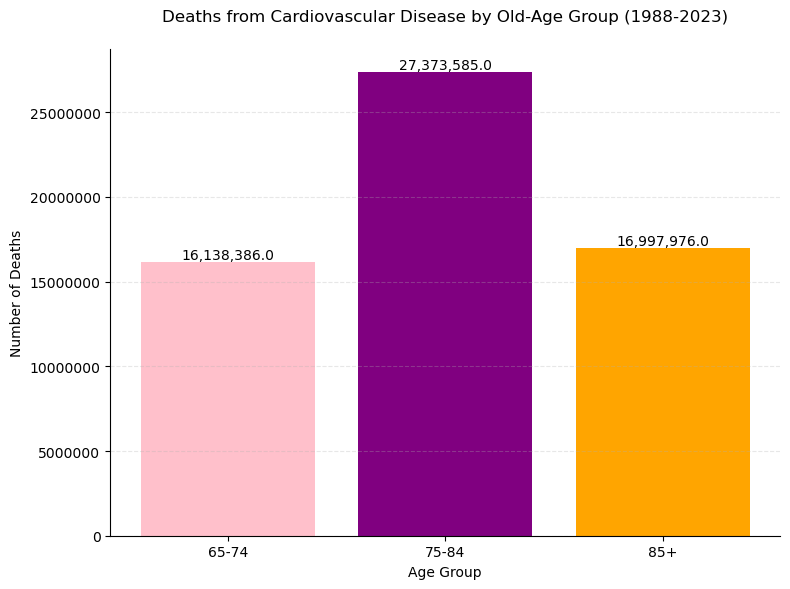

In [221]:
colors = ['pink', 'purple','orange']
fig, ax=plt.subplots(figsize=(8,6))
bars=ax.bar(old_disease1['Age_Group'], old_disease1['Deaths_number'], color=colors)
ax.set_title('Deaths from Cardiovascular Disease by Old-Age Group (1988-2023)', pad=20)
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Deaths')
ax.ticklabel_format(style='plain', axis='y')

for bar in bars:
    height= bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:,}', ha='center', va='bottom')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

>- There is indeed a significant difference of mortality rates from Cardiovascular Disease by Old-age Group.
>- The middle-old (75-84) age group surprisingly shows the most highest mortality rates compared to Oldest-old (85+) age group followed by the early-old (65-74) age group.
>- The oldest-old (85+) typically is expected to have highest mortality. This is probably due to unrecorded death registration in nursing homes or maybe most of them die due to different cause.
>- However, we cannot being a judgemental towards the eldest because some of the eldest are maintaining their nutrient and are healthy survivors.
>- We can assume that middle-age is the age where maybe they're hardworking when they're young, forgot to take care of themselves and in the end they suffered when they retired. We can study further if there's other demograhic features such as 'livind area', 'job background'.

#### 2) How differ the three most high cause of deaths of oldest-old (85+) age group between United States of America and Russian Federation?
>- These two country are chosen to compare with as the two are the most highest mortality rates in previous analysis.

In [238]:
stable_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


In [234]:
oldestold_causedeath1 #top 3 cause of death

,Death_cause,Oldest_old
0,Cardiovascular Diseases,16997976.0
1,Influenza and Pneumonia,3227662.0
2,Neurological/Mental Health,3064751.0


In [243]:
cause_map

{'1064': 'Cardiovascular Diseases',
 '1067': 'Cardiovascular Diseases',
 'I219': 'Cardiovascular Diseases',
 'I251': 'Cardiovascular Diseases',
 '1069': 'Cardiovascular Diseases',
 'I64': 'Cardiovascular Diseases',
 'J449': 'Respiratory Diseases',
 'JI89': 'Respiratory Diseases',
 'C349': 'Cancers/Neoplasm',
 '1026': 'Cancers/Neoplasm',
 'F03': 'Neurological/Mental Health',
 'R54': 'Geriatric',
 'J189': 'Influenza and Pneumonia'}

In [249]:
#Extract the data we want which we group the stable data with country and cause and sort it the from the highest number of deaths
top_causeoold= stable_mortality.groupby(['Country','Cause'], as_index=False)['Oldest_old'].sum().sort_values(by='Oldest_old', ascending=False)

#extract out the 'all causes' of dead from the dataframe so that we analyse the specific cause of deaths with name
top_causeoold= top_causeoold[~top_causeoold['Cause'].isin(['AAA', '1000'])]

#name the country and the cause of death by merging the dataframe with country codes and mapping with cause of death
top_causeoold1= pd.merge(top_causeoold, code, on='Country', how='left').drop(columns='Country').rename(columns= {'Name':'Country'})
top_causeoold1['Death_cause']= top_causeoold1['Cause'].map(cause_map)
top_causeoold1= top_causeoold1.drop(columns='Cause')
top_causeoold1.head()

,Oldest_old,Country,Death_cause
0,3634505.0,Russian Federation,Cardiovascular Diseases
1,1777597.0,Russian Federation,Cardiovascular Diseases
2,1488768.0,United States of America,Cardiovascular Diseases
3,1408956.0,Russian Federation,Cardiovascular Diseases
4,1082910.0,Japan,Influenza and Pneumonia


In [254]:
top_causecon= top_causeoold1[(top_causeoold1['Country'].isin(['Russian Federation', 'United States of America'])) & (top_causeoold1['Death_cause'].isin(['Cardiovascular Diseases','Influenza and Pneumonia', 'Neurological/Mental Health']))]
top_causecountry= top_causecon.groupby(['Country', 'Death_cause'], as_index=False)['Oldest_old'].sum().sort_values(by='Oldest_old', ascending=False)
top_causecountry

,Country,Death_cause,Oldest_old
0,Russian Federation,Cardiovascular Diseases,6821058.0
1,United States of America,Cardiovascular Diseases,2908937.0
3,United States of America,Neurological/Mental Health,1058833.0
2,United States of America,Influenza and Pneumonia,441651.0


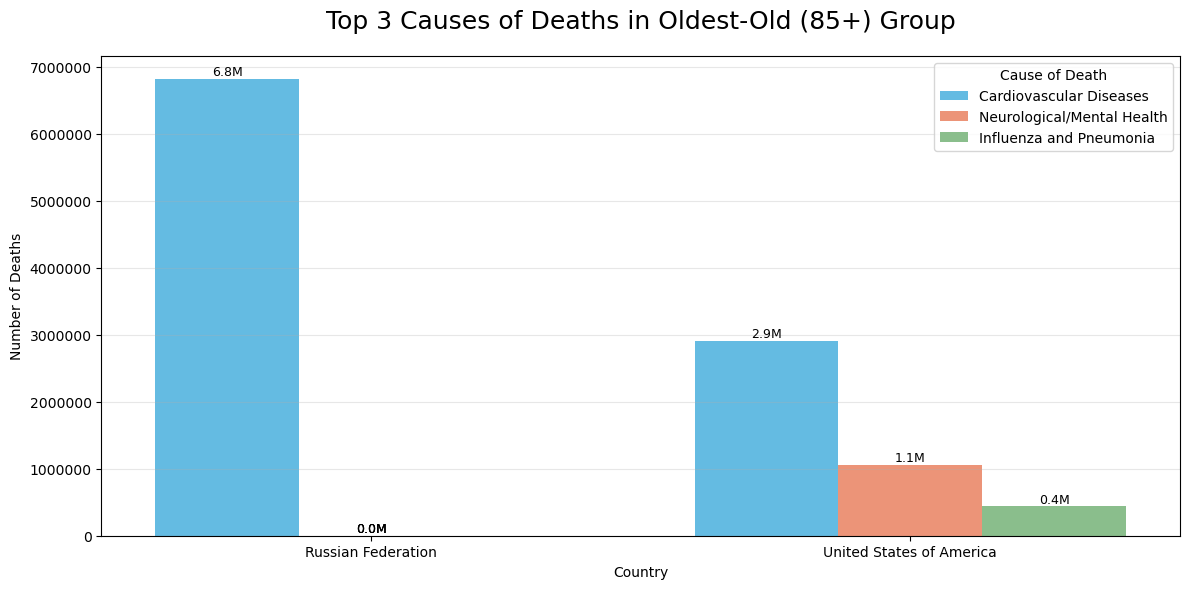

In [269]:
#top_causecountry= top_causecountry.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_causecountry, x='Country', y='Oldest_old', hue='Death_cause',
            palette=['#4FC3F7', '#FF8A65', '#81C784'])
plt.title('Top 3 Causes of Deaths in Oldest-Old (85+) Group', fontsize=18, pad=20)
plt.xlabel('Country')
plt.ylabel('Number of Deaths')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Cause of Death')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add labels to graph for clearer vision
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/1000000:.1f}M', (x + width/2, y + height + 50000),
                ha='center', fontsize=9)

plt.show();

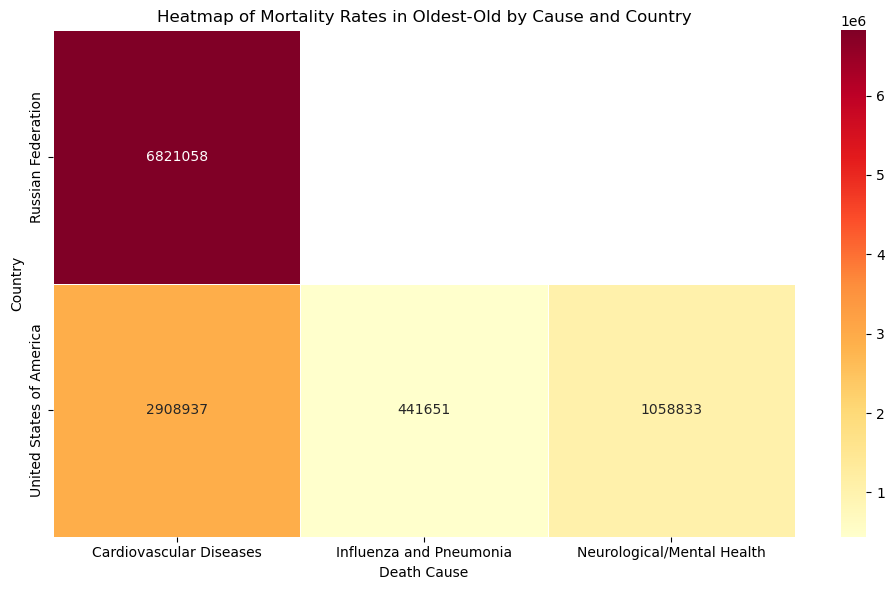

In [277]:
pivot_topcauseold = top_causecountry.pivot(index='Country', columns='Death_cause', values='Oldest_old')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_topcauseold, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5)
plt.title('Heatmap of Mortality Rates in Oldest-Old by Cause and Country')
plt.ylabel('Country')
plt.xlabel('Death Cause')
plt.tight_layout()
plt.show();

>- Top 2 countries with highest mortality rate:
>>- United States of America
>>- Russian Federation

>- Top 3 causes of deaths:
>>- Cardiovascular Diseases
>>- Influenza and Pneumonia
>>- Neurological/Mental Health

>- Between two top countries that dominates to higher mortality rates from year 1988-2023, United States of America has all of the top 3 diseases which conforms that this country is the 1st rank with highest mortality rate compared to Russian Federation and other countries.
>- This is expected due to huge demograhic area and population size of the country compared to others. Besides, US is well known for its upmost technologies, knowledge, sciences, thus means that there's high possibility they are experience high work pressure, workload in order to maintain their well socioeconomics.
>- Eventhough, US is a well forward country, they probably have poor healthcare system and fails in maintaining healthy lifestyle as they mostly eat fastfood compared to good nutrition food. 
>- While Russian Federation is 2nd highest mortality rate but only with the cardiovascular disease. The population size also bigger but I can say that healthcare system in this country probably more effective than in US as we can see that it only dominates to Cardiovascular disease which is the top cause death.
>- Other than that, Russian people also facing pressure with workload and socioeconomics that are very competitive in their country.